In [1]:
!pip install torch_geometric torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 658.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metad

In [2]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import SNRAdam
from SNRAdam import SNRAdam
import torch_optimizer as optim
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from IPython.display import display

In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

# Check the dataset
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')


Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [4]:
data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Is undirected: True


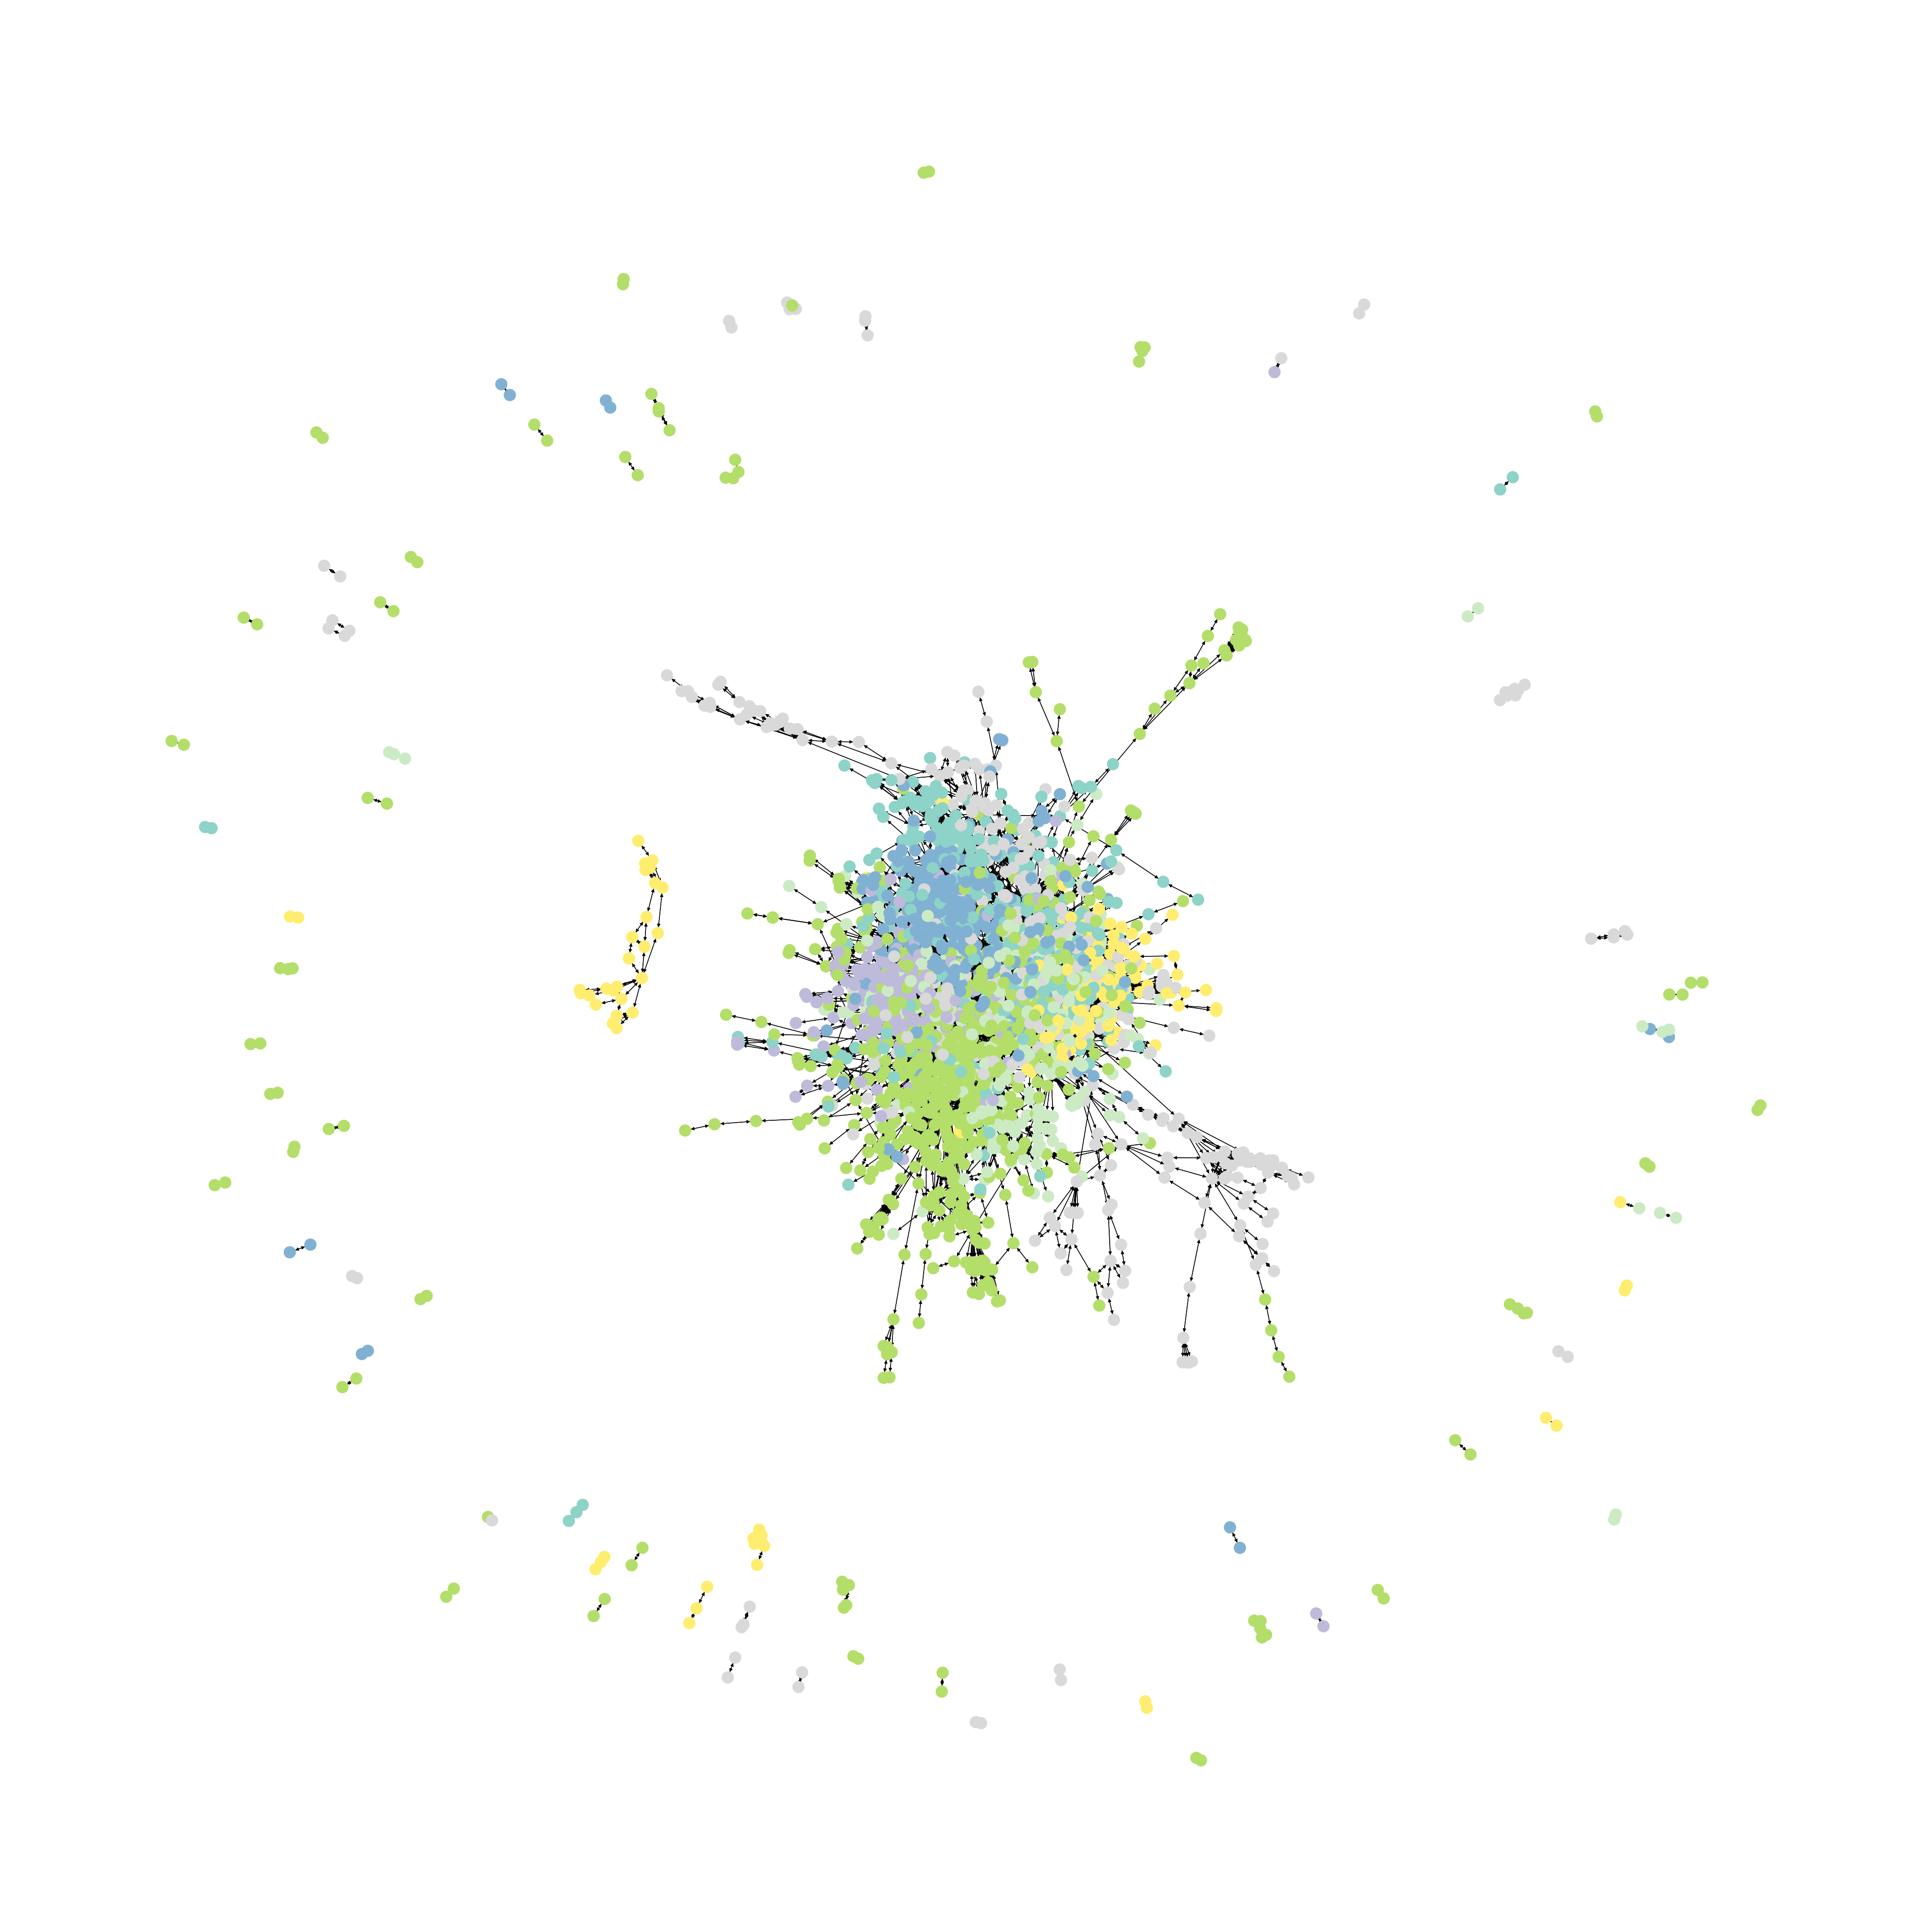

In [5]:
data = dataset[0]
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

plt.figure(figsize=(40, 40))
nx.draw(G, with_labels=False, node_color=data.y, cmap=plt.get_cmap('Set3'))
plt.show()

#GCN

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 16)
        self.conv4 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()
print(model)


GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 16)
  (conv4): GCNConv(16, 7)
)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

In [8]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

            _, train_pred = out.max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = out.max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            print(f'Epoch {epoch}/{num_epochs - 1}, '
                  f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model)
                if early_stopping.early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    if early_stopping:
        model.load_state_dict(torch.load('checkpoint.pt'))
    return model, train_accuracies, val_accuracies, test_accuracies


def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_model(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

In [9]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.0786, Validation Accuracy: 0.1000
Epoch 1/199, Training Accuracy: 0.0929, Validation Accuracy: 0.1080
Epoch 2/199, Training Accuracy: 0.0857, Validation Accuracy: 0.1040
Epoch 3/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1020
Epoch 4/199, Training Accuracy: 0.0929, Validation Accuracy: 0.1120
Epoch 5/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1100
Epoch 6/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1080
Epoch 7/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1060
Epoch 8/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1200
Epoch 9/199, Training Accuracy: 0.1143, Validation Accuracy: 0.1460
Epoch 10/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1680
Early stopping at epoch 10
Train Accuracy: 0.1357, Validation Accuracy: 0.1680, Test Accuracy: 0.1980
-------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 0/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 1/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 2/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 3/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 4/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 5/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 6/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 7/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 8/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 9/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 10/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Early stopping at epoch 10
Train Accuracy: 0.1857, Validation Accuracy: 0.1640, Test Accuracy: 0.1450


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1260
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 5/199, Training Accuracy: 0.2714, Validation Accuracy: 0.1500
Epoch 6/199, Training Accuracy: 0.5357, Validation Accuracy: 0.2800
Epoch 7/199, Training Accuracy: 0.2286, Validation Accuracy: 0.2280
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 9/199, Training Accuracy: 0.3143, Validation Accuracy: 0.1600
Epoch 10/199, Training Accuracy: 0.5571, Validation Accuracy: 0.4380
Epoch 11/199, Training Accuracy: 0.4143, Validation Accuracy: 0.3120
Epoch 12/199, Training Accuracy: 0.3071, Validation Accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 12/199, Training Accuracy: 0.4214, Validation Accuracy: 0.2800
Epoch 13/199, Training Accuracy: 0.5000, Validation Accuracy: 0.3160
Epoch 14/199, Training Accuracy: 0.5429, Validation Accuracy: 0.3500
Epoch 15/199, Training Accuracy: 0.6000, Validation Accuracy: 0.3900
Epoch 16/199, Training Accuracy: 0.6571, Validation Accuracy: 0.4380
Epoch 17/199, Training Accuracy: 0.6857, Validation Accuracy: 0.4700
Epoch 18/199, Training Accuracy: 0.7000, Validation Accuracy: 0.4840
Epoch 19/199, Training Accuracy: 0.7214, Validation Accuracy: 0.5020
Epoch 20/199, Training Accuracy: 0.6929, Validation Accuracy: 0.4820
Epoch 21/199, Training Accuracy: 0.6786, Validation Accuracy: 0.4800
Epoch 22/199, Training Accuracy: 0.6429, Validation Accuracy: 0.4780
Epoch 23/199, Training Accuracy: 0.6357, Validation Accuracy: 0.4800
Epoch 24/199, Training Accuracy: 0.6143, Validation Accuracy: 0.4500
Epoch 25/199, Training Accuracy: 0.6357, Validation Accuracy: 0.4500
Epoch 26/199, Training Accuracy: 0

In [10]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.078571         0.024781      0.078571        0.037187   
1      LBFGS        0.185714         0.127774      0.185714        0.112604   
2    RMSprop        0.950000         0.956293      0.950000        0.950790   
3      Rprop        0.985714         0.987013      0.985714        0.985871   
4       Adam        0.978571         0.979592      0.978571        0.978737   
5    Adagrad        0.992857         0.993197      0.992857        0.992853   
6   Adadelta        0.207143         0.064034      0.207143        0.096599   
7      RAdam        0.978571         0.979870      0.978571        0.978728   
8      NAdam        0.957143         0.963203      0.957143        0.957044   
9      AdamW        0.957143         0.963203      0.957143        0.957445   
10   SNRAdam        0.978571         0.978912      0.978571        0.978567   

    Test Accuracy  Test Precis

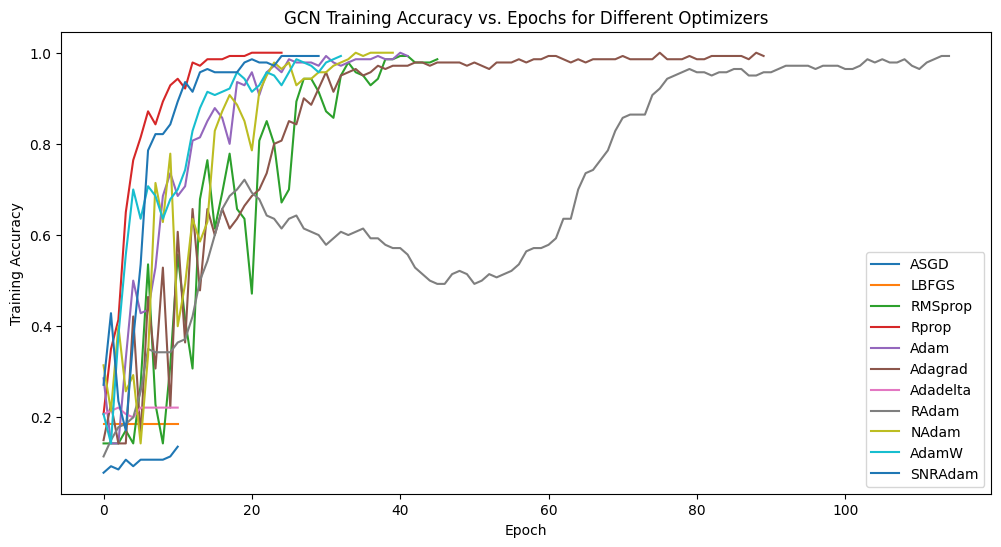

In [11]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('GCN Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

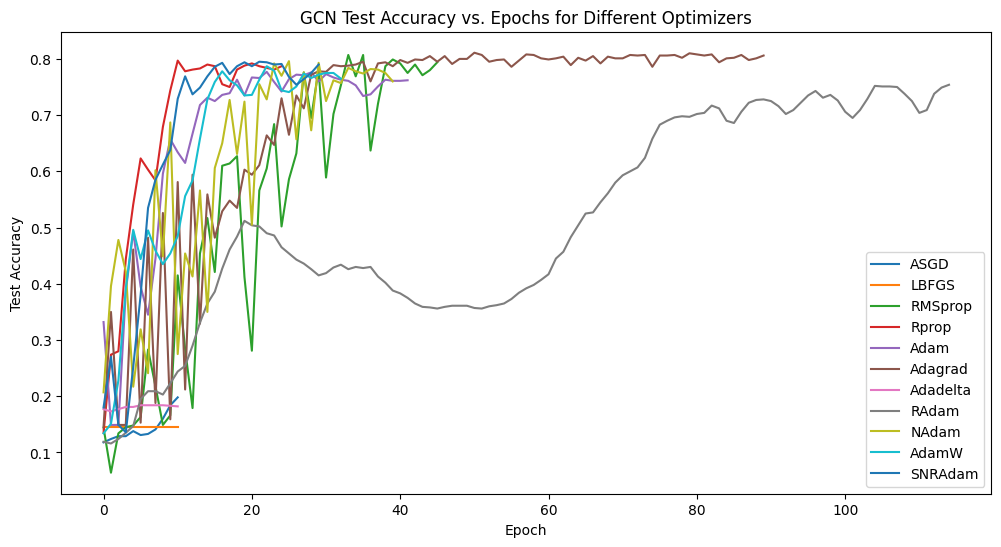

In [12]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('GCN Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

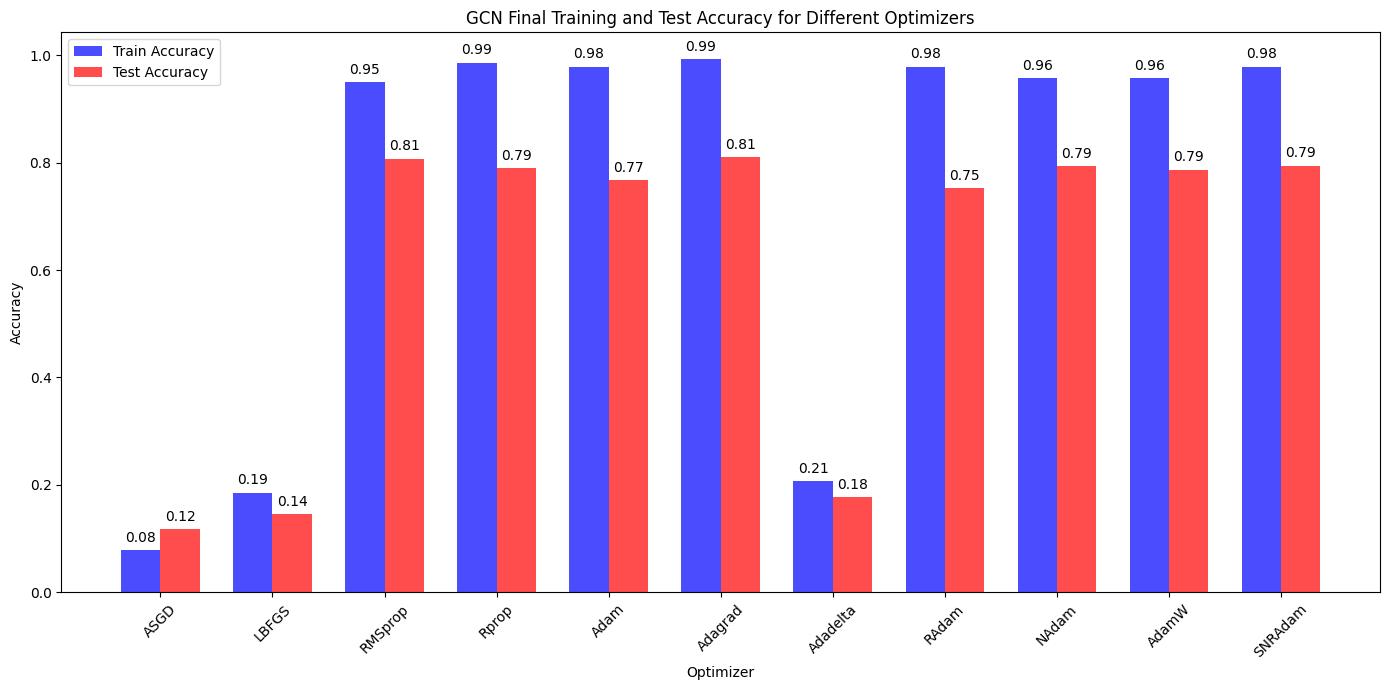

In [13]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('GCN Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#GAT

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, 128, heads=16, dropout=0.3)
        self.conv2 = GATConv(128 * 16, 64, heads=8, dropout=0.3)
        self.conv3 = GATConv(64 * 8, 16, heads=4, dropout=0.3)
        self.conv4 = GATConv(16 * 4, dataset.num_classes, heads=1, concat=False, dropout=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT()
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}/{num_epochs - 1}, '
                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_model(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

GAT(
  (conv1): GATConv(1433, 128, heads=16)
  (conv2): GATConv(2048, 64, heads=8)
  (conv3): GATConv(512, 16, heads=4)
  (conv4): GATConv(64, 7, heads=1)
)


In [15]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GATConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1214, Validation Accuracy: 0.2300
Epoch 1/199, Training Accuracy: 0.1357, Validation Accuracy: 0.2060
Epoch 2/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1920
Epoch 3/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1780
Epoch 4/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1980
Epoch 5/199, Training Accuracy: 0.1286, Validation Accuracy: 0.2160
Epoch 6/199, Training Accuracy: 0.1214, Validation Accuracy: 0.2260
Epoch 7/199, Training Accuracy: 0.1357, Validation Accuracy: 0.2040
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.2320
Epoch 9/199, Training Accuracy: 0.1500, Validation Accuracy: 0.2240
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.2200
Epoch 11/199, Training Accuracy: 0.1500, Validation Accuracy: 0.2240
Epoch 12/199, Training Accuracy: 0.1500, Validation Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 3/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 4/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 5/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 6/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 7/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 8/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 9/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 10/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 11/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 12/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Epoch 13/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1520
Early stopping at epoch 13
Train Accuracy: 0.1286, Validation Accuracy: 0.1520, Test Accuracy: 0.1620
--------------------------------------------------
Optimizer: RMSprop
--------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 2/199, Training Accuracy: 0.3143, Validation Accuracy: 0.2180
Epoch 3/199, Training Accuracy: 0.3500, Validation Accuracy: 0.2440
Epoch 4/199, Training Accuracy: 0.6714, Validation Accuracy: 0.5060
Epoch 5/199, Training Accuracy: 0.5214, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.8929, Validation Accuracy: 0.7320
Epoch 7/199, Training Accuracy: 0.8929, Validation Accuracy: 0.7280
Epoch 8/199, Training Accuracy: 0.7571, Validation Accuracy: 0.5280
Epoch 9/199, Training Accuracy: 0.9071, Validation Accuracy: 0.7040
Epoch 10/199, Training Accuracy: 0.9500, Validation Accuracy: 0.7680
Epoch 11/199, Training Accuracy: 0.9571, Validation Accuracy: 0.7720
Epoch 12/199, Training Accuracy: 0.9500, Validation Accuracy: 0.6980
Epoch 13/199, Training Accuracy: 0.9357, Validation Accuracy: 0.6880
Epoch 14/199, Training Accuracy: 0.9714, Validation Accuracy: 0.7340
Epoch 15/199, Training Accuracy: 0.9929, Validation Accuracy: 0.7560
Epoch 16/199, Training Accuracy: 0.9714, V

In [16]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.121429         0.052318      0.121429        0.068182   
1      LBFGS        0.128571         0.082707      0.128571        0.098002   
2    RMSprop        0.142857         0.020408      0.142857        0.035714   
3      Rprop        0.985714         0.987013      0.985714        0.985871   
4       Adam        0.971429         0.972691      0.971429        0.971205   
5    Adagrad        1.000000         1.000000      1.000000        1.000000   
6   Adadelta        0.050000         0.031821      0.050000        0.037881   
7      RAdam        0.971429         0.972727      0.971429        0.971586   
8      NAdam        0.914286         0.927894      0.914286        0.905989   
9      AdamW        0.950000         0.953640      0.950000        0.949463   
10   SNRAdam        0.964286         0.971429      0.964286        0.965426   

    Test Accuracy  Test Precis

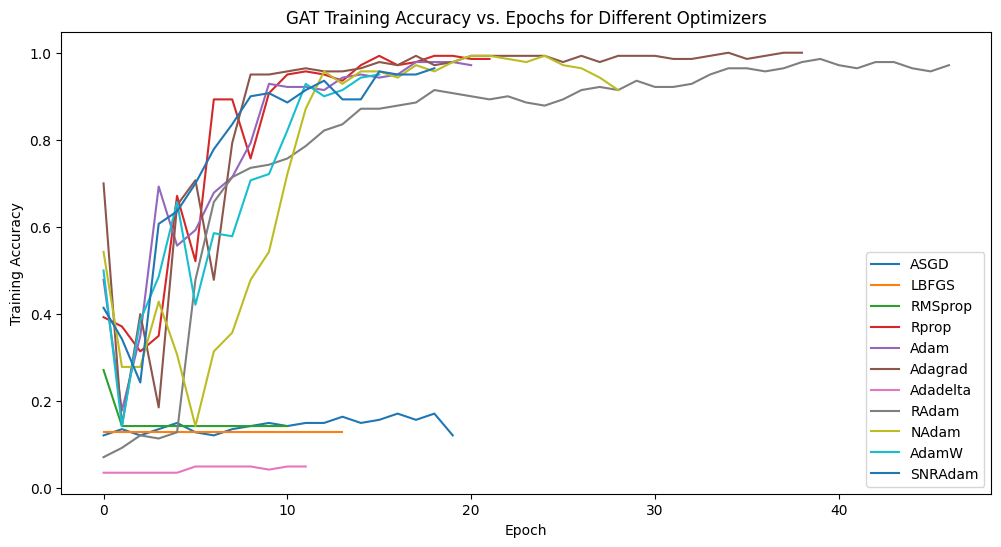

In [17]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('GAT Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

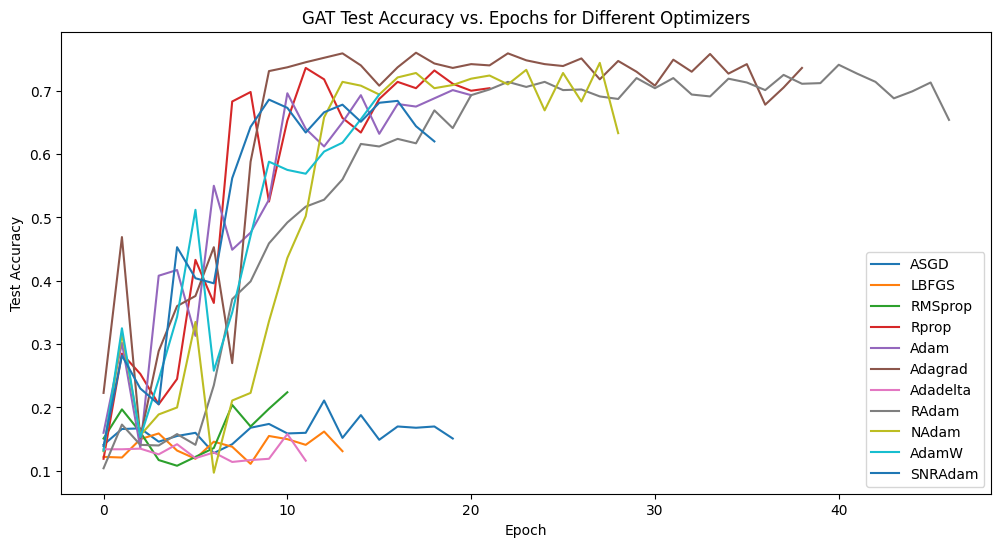

In [18]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('GAT Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

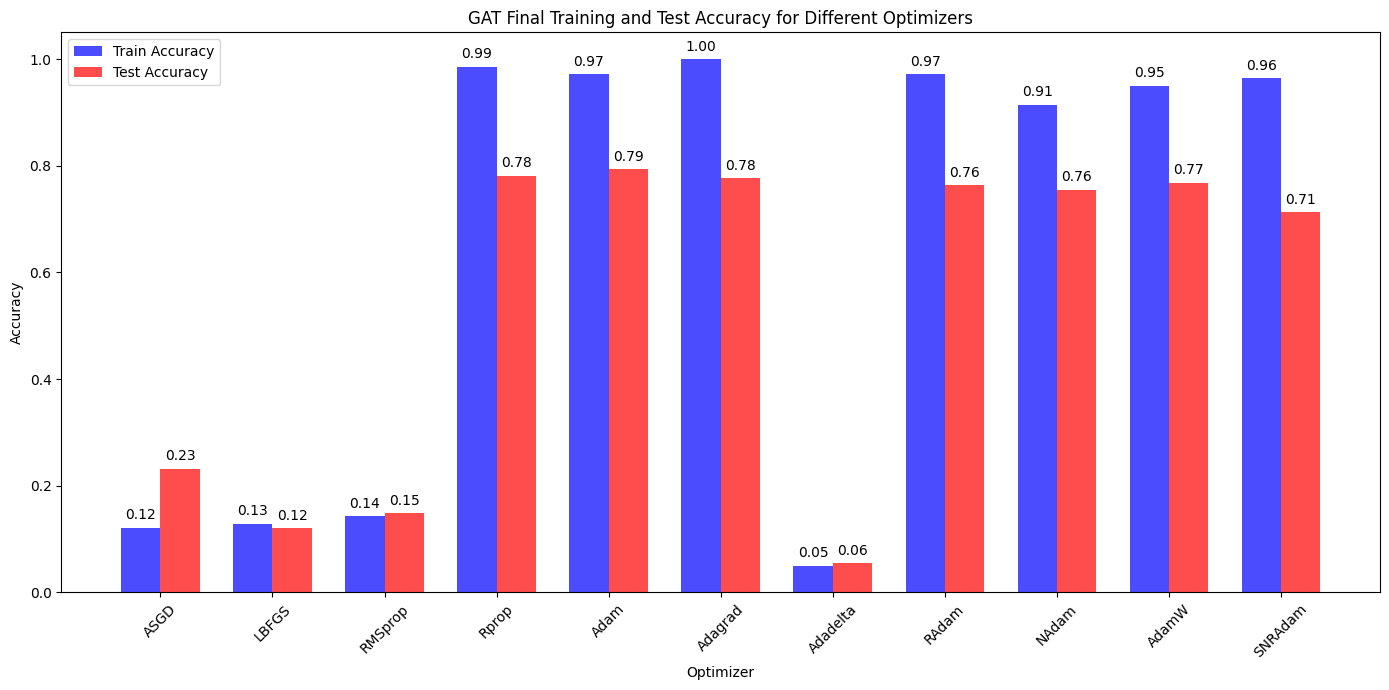

In [19]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('GAT Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#GraphSAGE

In [20]:
# https://arxiv.org/abs/1706.02216
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, 16)
        self.conv4 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (conv4): SAGEConv(16, 7, aggr=mean)
)


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, 16)
        self.conv4 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}/{num_epochs - 1}, '
                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())
    test_accuracies.append(test_acc)

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_model(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (conv4): SAGEConv(16, 7, aggr=mean)
)


In [22]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, SAGEConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 12/199, Training Accuracy: 0.1429, Validation Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Early stopping at epoch 11
Train Accuracy: 0.1429, Validation Accuracy: 0.0720, Test Accuracy: 0.1700
--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 2/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0640
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 4/199, Training Accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 18/199, Training Accuracy: 0.4929, Validation Accuracy: 0.3760
Epoch 19/199, Training Accuracy: 0.6929, Validation Accuracy: 0.5080
Epoch 20/199, Training Accuracy: 0.5571, Validation Accuracy: 0.5960
Epoch 21/199, Training Accuracy: 0.6786, Validation Accuracy: 0.6080
Epoch 22/199, Training Accuracy: 0.6857, Validation Accuracy: 0.6280
Epoch 23/199, Training Accuracy: 0.6214, Validation Accuracy: 0.6540
Epoch 24/199, Training Accuracy: 0.7857, Validation Accuracy: 0.6380
Epoch 25/199, Training Accuracy: 0.5214, Validation Accuracy: 0.5840
Epoch 26/199, Training Accuracy: 0.4643, Validation Accuracy: 0.4120
Epoch 27/199, Training Accuracy: 0.6429, Validation Accuracy: 0.4060
Epoch 28/199, Training Accuracy: 0.7214, Validation Accuracy: 0.4680
Epoch 29/199, Training Accuracy: 0.7429, Validation Accuracy: 0.5600
Epoch 30/199, Training Accuracy: 0.8429, Validation Accuracy: 0.6800
Epoch 31/199, Training Accuracy: 0.7643, Validation Accuracy: 0.5840
Epoch 32/199, Training Accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 12/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 13/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 14/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 15/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 16/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 17/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 18/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 19/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3140
Epoch 20/199, Training Accuracy: 0.1571, Validation Accuracy: 0.3140
Epoch 21/199, Training Accuracy: 0.1929, Validation Accuracy: 0.3180
Epoch 22/199, Training Accuracy: 0.2643, Validation Accuracy: 0.2840
Early stopping at epoch 22
Train Accuracy: 0.2643, Validation Accuracy: 0.3180, Test Accuracy: 0.2930
--------------------------------------------------
Optimizer: NAdam
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 7/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1200
Epoch 8/199, Training Accuracy: 0.2929, Validation Accuracy: 0.3080
Epoch 9/199, Training Accuracy: 0.5571, Validation Accuracy: 0.3600
Epoch 10/199, Training Accuracy: 0.5500, Validation Accuracy: 0.4740
Epoch 11/199, Training Accuracy: 0.3643, Validation Accuracy: 0.2280
Epoch 12/199, Training Accuracy: 0.3929, Validation Accuracy: 0.3260
Epoch 13/199, Training Accuracy: 0.5429, Validation Accuracy: 0.4180
Epoch 14/199, Training Accuracy: 0.6714, Validation Accuracy: 0.5120
Epoch 15/199, Training Accuracy: 0.6357, Validation Accuracy: 0.4720
Epoch 16/199, Training Accuracy: 0.5000, Validation Accuracy: 0.3640
Epoch 17/199, Training Accuracy: 0.7571, Validation Accuracy: 0.5940
Epoch 18/199, Training Accuracy: 0.9143, Validation Accuracy: 0.7380
Epoch 19/199, Training Accuracy: 0.9143, Validation Accuracy: 0.7300
Epoch 20/199, Training Accuracy: 0.8143, Validation Accuracy: 0.7100
Epoch 21/199, Training Accuracy: 0.95

In [23]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.142857         0.020408      0.142857        0.035714   
1      LBFGS        0.142857         0.020408      0.142857        0.035714   
2    RMSprop        0.971429         0.973408      0.971429        0.970356   
3      Rprop        0.971429         0.973067      0.971429        0.971388   
4       Adam        0.835714         0.862322      0.835714        0.817350   
5    Adagrad        0.992857         0.993197      0.992857        0.992853   
6   Adadelta        0.142857         0.020408      0.142857        0.035714   
7      RAdam        0.264286         0.080770      0.264286        0.122428   
8      NAdam        0.992857         0.993197      0.992857        0.992853   
9      AdamW        0.992857         0.993197      0.992857        0.992853   
10   SNRAdam        1.000000         1.000000      1.000000        1.000000   

    Test Accuracy  Test Precis

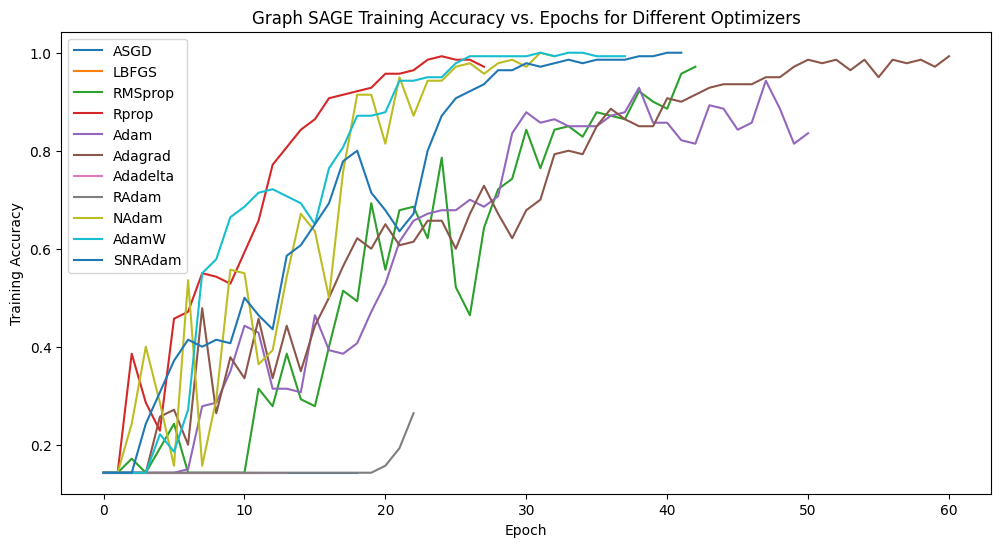

In [24]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Graph SAGE Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

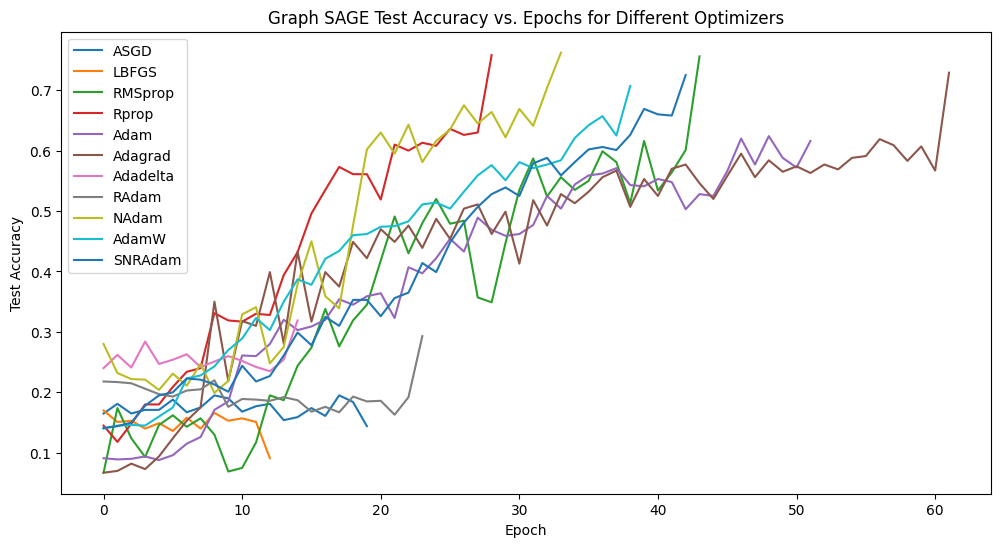

In [25]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Graph SAGE Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

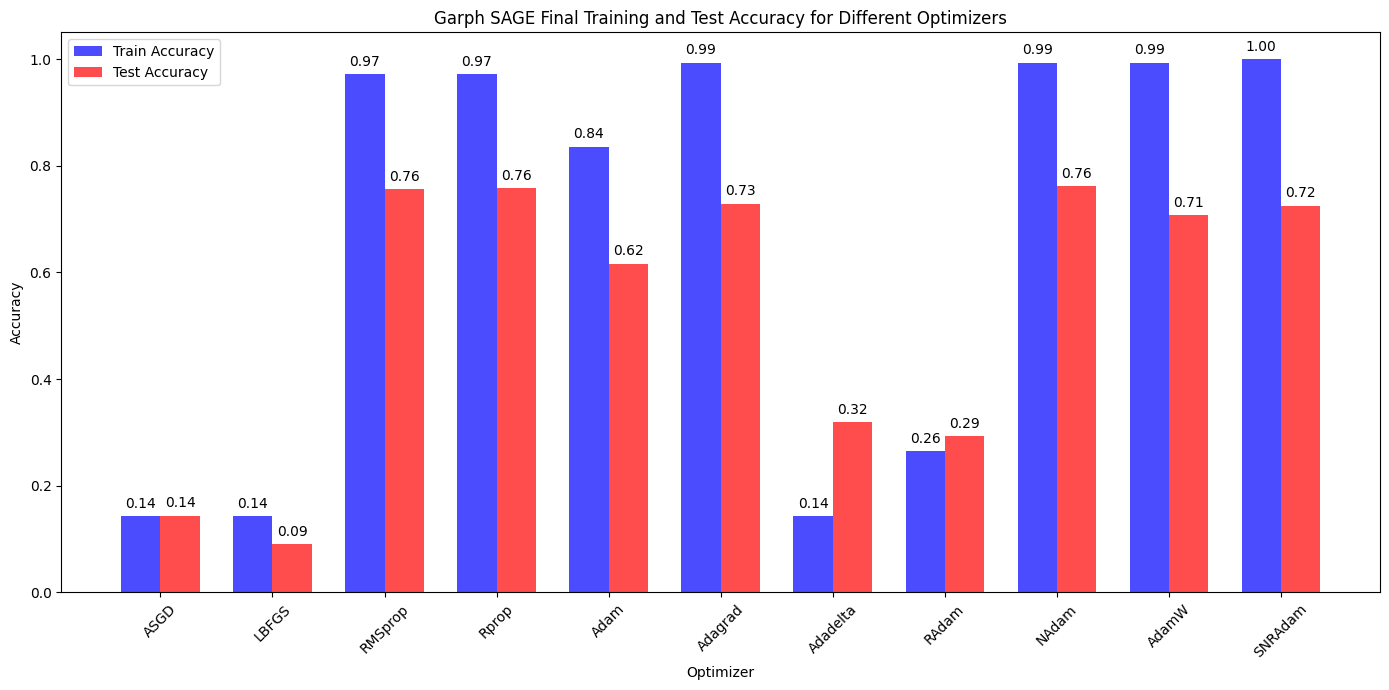

In [26]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('Garph SAGE Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#GAE

In [27]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
import torch.nn as nn
import torch.optim as optim

class GCNEncoder(torch.nn.Module):
    def __init__(self):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32, cached=True)
        self.conv2 = GCNConv(32, 16, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_channels = 16
num_features = dataset.num_features

model = GAE(GCNEncoder()).to(device)
x = data.x.to(device)
edge_index = data.edge_index.to(device)
criterion = nn.CrossEntropyLoss()

# Define the NodeClassifier
class NodeClassifier(nn.Module):
    def __init__(self):
        super(NodeClassifier, self).__init__()
        self.linear = nn.Linear(16, dataset.num_classes)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)

classifier = NodeClassifier().to(device)
criterion = nn.CrossEntropyLoss()
labels = data.y.to(device)
train_mask = data.train_mask.to(device)
val_mask = data.val_mask.to(device)
test_mask = data.test_mask.to(device)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, edge_index)
    loss = model.recon_loss(z, edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

def evaluate_model(embeddings, mask):
    classifier.eval()
    with torch.no_grad():
        out = classifier(embeddings)
        pred = out[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
    return acc

def train_classifier():
    classifier.train()
    optimizer.zero_grad()
    out = classifier(embeddings)
    loss = criterion(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test_classifier(mask):
    classifier.eval()
    with torch.no_grad():
        out = classifier(embeddings)
        pred = out[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
    return acc

def train_model(model, criterion, optimizer, data, num_epochs=25, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        z = model.encode(data.x.to(device), data.edge_index.to(device))
        loss = model.recon_loss(z, data.edge_index.to(device))
        loss.backward()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                z = model.encode(data.x.to(device), data.edge_index.to(device))
                loss = model.recon_loss(z, data.edge_index.to(device))
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
        train_acc = evaluate_model(embeddings, data.train_mask)
        val_acc = evaluate_model(embeddings, data.val_mask)
        test_acc = evaluate_model(embeddings, data.test_mask)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch}/{num_epochs - 1}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

        if early_stopping:
            early_stopping(val_acc, model, epoch)
            if early_stopping.early_stop:
                early_stopping.load_best_model(model)
                break

    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_classification_performance(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
        out = classifier(embeddings)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=25, patience=10):

    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
    train_acc = evaluate_model(embeddings, data.train_mask)
    val_acc = evaluate_model(embeddings, data.val_mask)
    test_acc = evaluate_model(embeddings, data.test_mask)

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_classification_performance(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

# Different optimizers
lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam': SNRAdam(model.parameters(), lr=lr)
}

In [28]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GAE)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1140, Test Accuracy: 0.1030
-------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1240
Epoch 4/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1240
Epoch 5/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1260
Epoch 6/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1260
Epoch 7/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1260
Epoch 8/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1260
Epoch 9/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1280
Epoch 10/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1280
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1280, Test Accuracy: 0.1280
--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------
Epoch 0/199, Training Accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Early stopping at epoch 11
Train Accuracy: 0.1429, Validation Accuracy: 0.3100, Test Accuracy: 0.3160
--------------------------------------------------
Optimizer: Rprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1140, Test Accuracy: 0.1030
--------------------------------------------------
Optimizer: Adam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1160
Epoch 4/199, Training Accuracy: 0.1643, Validation Accuracy: 0.1180
Epoch 5/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1200
Epoch 6/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1160
Epoch 7/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1160
Epoch 8/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1160
Epoch 9/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1160
Epoch 10/199, Training Accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

--------------------------------------------------
Optimizer: Adagrad
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 1/199, Training Accuracy: 0.1786, Validation Accuracy: 0.1160
Epoch 2/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1320
Epoch 4/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1240
Epoch 5/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1300
Epoch 6/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1260
Epoch 7/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1320
Epoch 8/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1260
Epoch 9/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1380
Epoch 10/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1320
Early stopping at epoch 10
Train Accuracy: 0.1786, Validation Accuracy: 0.1380, Test Accuracy: 0.1430
----------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1140, Test Accuracy: 0.1030
--------------------------------------------------
Optimizer: RAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 10/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1120
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 12/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1160
Epoch 13/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1180
Epoch 14/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 15/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1160
Epoch 16/199, Training Accuracy: 0.1429, V

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1140, Test Accuracy: 0.1030
--------------------------------------------------
Optimizer: SNRAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 6/199, Training Accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1140, Test Accuracy: 0.1030


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.142857         0.020408      0.142857        0.035714   
1      LBFGS        0.121429         0.019274      0.121429        0.033268   
2    RMSprop        0.142857         0.020408      0.142857        0.035714   
3      Rprop        0.142857         0.020408      0.142857        0.035714   
4       Adam        0.178571         0.065246      0.178571        0.078570   
5    Adagrad        0.157143         0.048122      0.157143        0.056784   
6   Adadelta        0.142857         0.020408      0.142857        0.035714   
7      RAdam        0.142857         0.020408      0.142857        0.035714   
8      NAdam        0.142857         0.022676      0.142857        0.039139   
9      AdamW        0.142857         0.020408      0.142857        0.035714   
10   SNRAdam        0.142857         0.020408      0.142857        0.035714   

    Test Accuracy  Test Precis

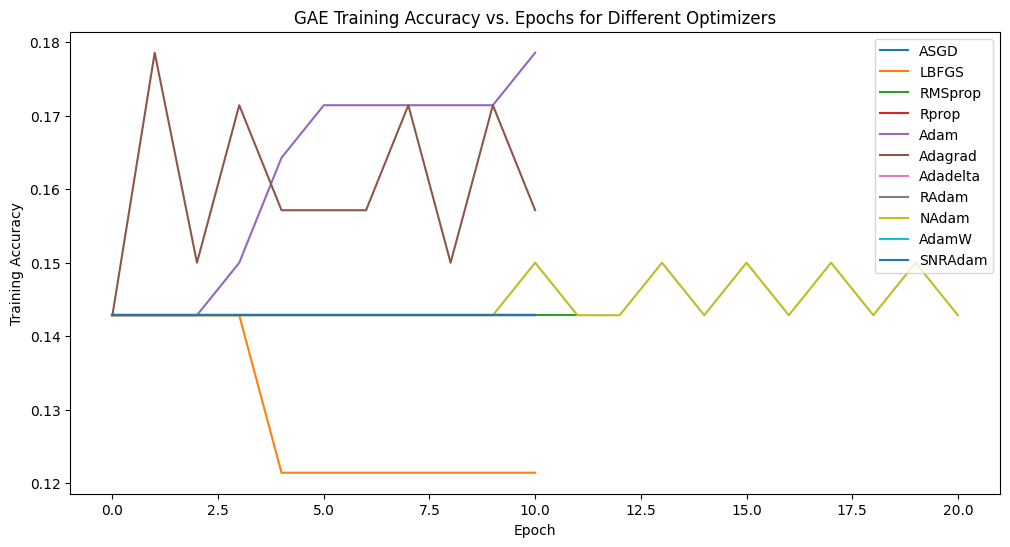

In [30]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('GAE Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

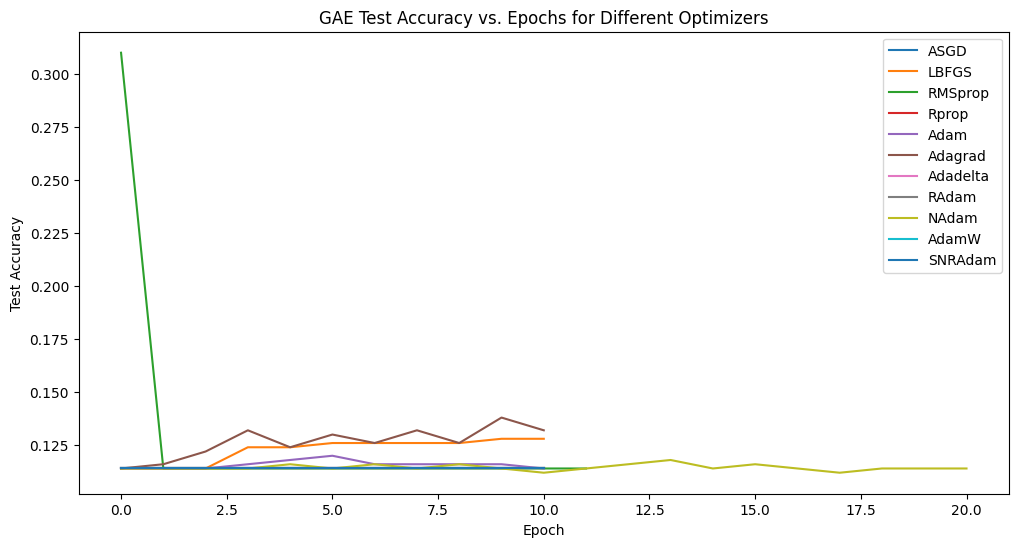

In [31]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_val_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('GAE Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

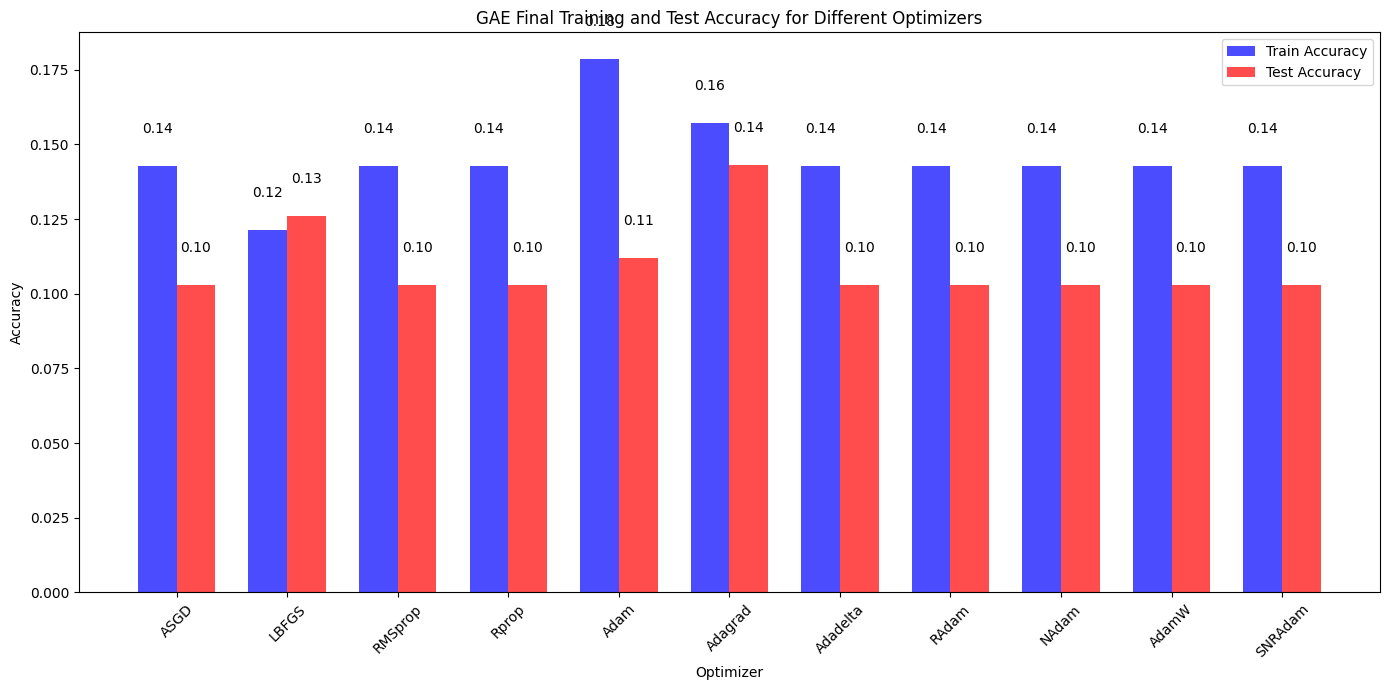

In [32]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('GAE Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()